# Ch. 10: Linear Regression

Topics to cover:

1. Interpretation
2. Frisch-Waugh Theorem
3. Role that variance has on Linear Regression
4. Linear Probability Models
5. Including unnecessary controls

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
import matplotlib.colors as colors
from numpy import linalg as LA
from scipy.linalg import svdvals
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}
axes = {
        'titlesize' : 22,
        'labelsize' : 20}
figure = {'figsize':(10,4),
         'autolayout':True}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('figure', **figure)


## 1. Interpretation

* Show that $\alpha_1 = \frac{Cov(x_1,y)}{Var(x_1)}$ in a one feature world
* Show that $\alpha_k = \frac{Cov(\tilde{x}_k,y)}{Var(\tilde{x}_k)}$ in a several feature world

where $\tilde{x}_k$  are the residuals of a linear regression of $x_k$ on all other features.

In [2]:
def simulate_xmatrix_rho(nobs, nfeats, rho, seed):
    """
    Simulate a feature matrix with normally distributed features
    """
    np.random.seed(seed)
    # first step: construct the vcv with unit variances and rho elsewhere
    pre_vcv = np.array([[rho]*nfeats]*nfeats)
    iden_mtx = np.eye(nfeats)
    vcv = iden_mtx + (1-iden_mtx)*pre_vcv
    # second step: draw from 
    mu = [0]*nfeats
    Xdf = pd.DataFrame(np.random.multivariate_normal(mean = mu, cov = vcv, size=nobs), 
                      columns = [f'x{i+1}' for i in range(nfeats)])
    return Xdf

In [3]:
def simulate_normal_linear_model(alpha, vcv_x, var_epsilon, seed, nobs, rho = None):
    """
    Function to simulate a linear model with normally distributed errors
    Inputs:
        alpha: array with K user-provided coefficients (includes intercept)
        vcv_x: array of dimension (K-1)x (K-1) covariance matrix for X.  Must be positive definite
        var_epsilon: variance for normal errors
        seed: random seed
        nobs: number of observations in the sample
        rho: if None --> vcv_x is passed by the user
            Otherwise VCV(rho) and overrides what the user passes
    output: y,X
    """
    np.random.seed(seed)
    K = len(alpha)
    alpha = np.array(alpha).reshape((K,1))   # make it a column vector
    # simulate K-1 normal random: all mean zero (means go to the intercept so it doesn't matter)
    mu = np.array([0]*(K-1)).reshape((K-1,1))
    if rho is None:
        prex = np.random.multivariate_normal(mean=mu.flatten(), cov=vcv_x, size=nobs)
    else:
        nfeats= len(mu)
        prex = simulate_xmatrix_rho(nobs=nobs, nfeats=nfeats, rho=rho, seed=seed)
    ones = np.array([1]*nobs).reshape((nobs,1))  
    X = np.concatenate((ones, prex), axis=1) # include first the column for the intercept
    col_labels = [f'x{num}' for num in range(K)]
    xdf = pd.DataFrame(X, columns = col_labels)
    epsilon = np.sqrt(var_epsilon)*np.random.randn(nobs,1)
    y = np.dot(X, alpha) + epsilon
    ydf = pd.DataFrame(y, columns = ['y'])
    return ydf, xdf

In [4]:
def percentile(n):
    """
    Percentile function to pass to Pandas agg method
    Taken from: https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function
        Note that top answer doesn't work well to handle multiple columns so I used a proposed fix in
        the thread (Thomas) that uses Pandas quantile method that works on any series
    """
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:2.0f}'.format(n*100)
    return percentile_

def create_means_bounds_mc(df, qmin = 0.05, qmax = 0.95):
    """
    Helper function to get the means and bounds for the plot_conf_intervals method
    df: dataframe with the results from the MonteCarlo simulation
    qmin, qmax: quantiles to create the CI (default is 90% CI)
    """
    df_agg = df.agg([np.mean, percentile(qmin), percentile(qmax)])
    return df_agg

def plot_conf_intervals(means, bounds, var_labels, ax, true_params = None, plot_bars = True):
    """
    Plot standard confidence intervals.  Box plots do the job, but this is more general function
        means: array: has the means to be plotted (could be estimated parameters)
        bounds: array: lower and upper bounds for the CI (size: 2 x number of columns)
        var_labels: 
        ax: axis object to create the plot
        true_params: array with true parameters if I want to plot them along (default: None)
        plot_bars: Boolean: if True: plot the bars, False: just plot the CI and means as marker
            Bars may unnecessarily clutter the plot (see first example below)
    Output:
        axis object with the plot
    """
    # check dimensions first
    if len(means)!=bounds.shape[1] or len(var_labels)!=len(means):
        raise ValueError("You must pass the same number of variables for means and bounds")
    # plot means as bars, confidence intervals as lines
    n_bars = len(means)
    width = 0.5
    G = 0.2*width # parameter to control the width of the CI
    if plot_bars:
        ax.bar(range(n_bars), means, color ='0.75', edgecolor = 'k', width = width, alpha = 0.5, 
              label='means')
    else:
        #x_scatter = [i-G*0.5 for i in range(n_bars)]
        #ax.scatter(x_scatter, means, color = '0.5', edgecolor = 'k', marker = '.', s = 30, 
        #      label='means')
        for i in range(n_bars):
            if i==0:
                ax.plot([i-G*0.5, i+G*0.5], [means[i], means[i]], color='k',ls='--', label='means')
            else:
                ax.plot([i-G*0.5, i+G*0.5], [means[i], means[i]], color='k',ls='--')
                
    for i in range(n_bars):
        ymin_i, ymax_i = bounds[:,i]
        if i==0:
            ax.plot([i, i], [ymin_i, ymax_i], color ='k', alpha = 1, label='CI')
        else:
            ax.plot([i, i], [ymin_i, ymax_i], color ='k', alpha = 1)
        ax.plot([i-G, i+G], [ymin_i, ymin_i], color ='k', alpha = 1, lw = 1)
        ax.plot([i-G, i+G], [ymax_i, ymax_i], color ='k', alpha = 1, lw = 1)
    # pass labels
    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(var_labels)
    # plot true parameters
    if true_params is not None:
        x_scatter_p = [i+G*0.5 for i in range(n_bars)]  # to improve visibility
        ax.scatter(x_scatter_p, true_params, marker = 's', color = 'k', s=30,
              label='true')
        
    xmin, xmax = ax.get_xlim()
    ax.plot([xmin, xmax], [0, 0], ls = '--', color = '0.2')
    ax.set_xlim([xmin, xmax]) # just to make the plot nicer: enforce plot's width
    ax.legend()
    return ax

In [48]:
# only one feature
alpha = [2, 3.5]
var_x = [3]
vcv_x = np.diag(var_x)
var_epsilon = 1
seed = 25431
nobs = 100
ydf, Xdf = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                                        seed=seed, nobs=nobs)
Xdf.var()

x0    0.000000
x1    2.805773
dtype: float64

In [49]:
def compute_alpha_1feat(ydf, xdf):
    """Compute alpha using var-cov formula and linear regression for the simple case of
        y = a + b x
    Inputs:
        ydf, xdf: dataframes with outcome and feature
    Outputs:
        Estimated coefficients from two methods: Cov() formula and linear regression
    """
    # Using covariance formula
    cat_mat = ydf.copy()
    cat_mat['x'] = xdf['x1']  # concatenate [y|x] so I can use the .cov() method
    vcv = cat_mat.cov()  
    cov_xy = vcv['y'].loc['x']
    var_x  = vcv['x'].loc['x']
    beta_vcv = cov_xy/var_x
    # using linear regression
    reg = LinearRegression(fit_intercept=True).fit(xdf, ydf.values.flatten())
    beta_reg = reg.coef_[0]

    
    return beta_vcv, beta_reg

In [50]:
b_vcv, b_reg = compute_alpha_1feat(ydf=ydf, xdf=Xdf[['x1']])
decimals = 10
print(f'Alpha vcv formula = {b_vcv.round(decimals=decimals)}, \nAlpha OLS = {b_reg.round(decimals=decimals)}')


Alpha vcv formula = 3.531180168, 
Alpha OLS = 3.531180168


In [51]:
def compute_alpha_n_feats(ydf, xdf, name_var):
    """
    Compute linear regression coefficients by:
        1. Orthogonalization (Cov formula)
        2. OLS
    Inputs: 
        ydf, xdf: dataframes with outcome and features
        name_var: string: name of feature you want to compute
    Outputs:
        Coefficient for name_var using both methods
            
    """
    # Run regression of name_var on all other features and save residuals
    cols_exc_x = np.array(list(set(xdf.columns) - set([name_var])))
    new_x = xdf[cols_exc_x]
    new_y = xdf[name_var]
    reg_x = LinearRegression().fit(new_x, new_y.values.flatten())
    resids_x = new_y - reg_x.predict(new_x)
    # Pass residuals to Cov formula
    cat_mat = ydf.copy()
    cat_mat['x'] = resids_x
    vcv = cat_mat.cov()
    cov_xy = vcv['y'].loc['x']
    var_x  = vcv['x'].loc['x']
    beta_vcv = cov_xy/var_x
    # using linear regression
    reg = LinearRegression().fit(xdf, ydf.values.flatten())
    all_betas = reg.coef_
    ix_var = np.where(xdf.columns == name_var)
    beta_reg = all_betas[ix_var][0]

    return beta_vcv, beta_reg

In [52]:
# several features
alpha = [2, 3.5, -2, 3]
var_x = [3]*3
vcv_x = np.diag(var_x)
var_epsilon = 1
seed = 44169
nobs = 100
ydf, Xdf = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                                        seed=seed, nobs=nobs)

name_var = 'x3'
b2_for, b2_for = compute_alpha_n_feats(ydf=ydf, xdf=Xdf, name_var=name_var)
decimals = 10
true_alpha = alpha[np.where(Xdf.columns == name_var)[0][0]]
print(f"""Alpha({name_var}) cov formula = {np.around(b2_for, decimals=decimals)}, 
        \nAlpha({name_var}) OLS = {np.around(b2_for, decimals=decimals)}
        \nTrue alpha({name_var}) = {true_alpha}""")


Alpha(x3) cov formula = 2.9534461492, 
        
Alpha(x3) OLS = 2.9534461492
        
True alpha(x3) = 3


## 2. Frisch-Waugh Theorem

Suppose that 
$$
y = \alpha_0 + \alpha_1 x_1 + \alpha_2 x_2 + \epsilon
$$

Call $x_{-k}$ the feature matrix where you _exclude_ feature $k$

FW theorem says: 
* You can estimate $\alpha_k$ by running OLS of $y$ on $(x_1, x_2)$, or
* Run three regressions:
    * Reg 1: y on $x_{-k}$ --> save residuals (`res_yk`)
    * Reg 2: x_k on $x_{-k}$ --> save residuals (`res_xk`)
    * Reg 3: res_yk on res_xk

In [53]:
def check_fw(ydf, xdf, var_name, version = 'residuals'):
    """
    Check the Frisch-Waugh theorem:
        Method 1: two-step regressions on partialled-out regressions
        Method 2: one-step regression
    Inputs:
        ydf, xdf: dataframes with Y and X respectively
        var_name: string: name of feature we want to apply the FW for
        version: string: ['residuals','direct'] can be used to test
            both covariance formulas presented in the chapter
    """
    # METHOD 1: two steps regressions
    nobs = ydf.shape[0]
    cols_exc_k = np.array(list(set(xdf.columns) - set([var_name])))
    x_k = xdf[cols_exc_k]
    # reg 1:
    reg_y = LinearRegression().fit(x_k, ydf.values.flatten())
    res_yk = ydf.values.flatten() - reg_y.predict(x_k)
    # reg 2:
    new_y = xdf[var_name]
    reg_x = LinearRegression().fit(x_k, new_y.values.flatten())
    res_xk = new_y.values.flatten() - reg_x.predict(x_k)
    res_xk = res_xk.reshape((nobs,1))
    # reg 3:
    if version=='residuals':
        reg_res = LinearRegression().fit(res_xk, res_yk)
    else:
        reg_res = LinearRegression().fit(res_xk, ydf.values.flatten())
    coef_fw = reg_res.coef_[0]
    # METHOD 2: OLS directly
    reg = LinearRegression().fit(xdf, ydf.values.flatten())
    coef_all = reg.coef_
    ix_var = np.where(xdf.columns == var_name)[0][0]
    coef_ols = coef_all[ix_var]
    
    return coef_fw, coef_ols

In [54]:
cols_to_include = set(Xdf.columns)-set(['x0'])
decimals= 5
print('--- Printing the results from OLS and FW two-step methods \nVersion = residuals ---')
for col in ['x1', 'x2', 'x3']:
    a, b = check_fw(ydf, xdf=Xdf[cols_to_include], var_name=col, version='residuals')
    print(f'{col}: FW two-steps = {a.round(decimals=decimals)}, OLS = {b.round(decimals=decimals)}')


--- Printing the results from OLS and FW two-step methods 
Version = residuals ---
x1: FW two-steps = 3.66436, OLS = 3.66436
x2: FW two-steps = -1.8564, OLS = -1.8564
x3: FW two-steps = 2.95345, OLS = 2.95345


In [55]:
print('--- Printing the results from OLS and FW two-step methods \nVersion = Direct ---')
for col in ['x1', 'x2', 'x3']:
    a, b = check_fw(ydf, xdf=Xdf[cols_to_include], var_name=col, version='direct')
    print(f'{col}: FW two-steps = {a.round(decimals=decimals)}, OLS = {b.round(decimals=decimals)}')


--- Printing the results from OLS and FW two-step methods 
Version = Direct ---
x1: FW two-steps = 3.66436, OLS = 3.66436
x2: FW two-steps = -1.8564, OLS = -1.8564
x3: FW two-steps = 2.95345, OLS = 2.95345


## Let's simulate a more convoluted model to see the power of FW
* y = f(x1,x2)
* x2 = g(x1,z)

Idea: `x2` is itself a function of `x1`

Think of geographic dummies: they usually have a direct and an indirect effect

In [56]:
def find_categorical_variables(xdf):
    """This function automates finding categorical/dummy variables
    Inputs:
        xdf: dataframe with the features used in training a model
    Outputs:
        df_counts: a mapping of each feature in Xdf with it's type
    """
    # first step: find those that might be dummies numerically 
    # This is important for binary dummies: for non-binary we need to be careful
    xcols = xdf.columns
    # get first a mapping of feature --> type
    # Idea: count distinct values.  If more than 2 --> continuous (numerical)
    df_counts = pd.DataFrame(index = xcols, columns = ['counts','type','modal'])
    for c, col in enumerate(xcols):
        prec = xdf[col].value_counts()
        len_ix = len(prec.index)
        df_counts['counts'].loc[col] = len_ix
        # map to type and include the modal or mean for later use
        if len_ix >= 3:
            df_counts.type.loc[col] = 'numerical'
            mode_val = xdf[col].mean()
        elif len_ix == 1:
            df_counts.type.loc[col] = 'intercept'
            mode_val = prec.index[0]
        else:
            df_counts.type.loc[col] = 'categorical'
            mode_val = prec.index[0]
        df_counts['modal'].loc[col] = mode_val
    
    return df_counts

  

In [57]:
def create_pdp(xdf, name_var, model, drop_outliers = True, pmin = 0.01, pmax = 0.99, 
                   dict_specific_xs = None):
    """
    Create a partial dependence plot dataset: this function doesn't plot the results
    It creates a grid for the selected variable (name_var) and all other variables are evaluated
        on the means.
    Inputs:
        xdf: to get the means
        var_to_simulate: specific var to create a grid (if binary, I need to take care of dummy variables)
        model: model object from scikitlearn regression
        drop_outliers: Bool: if True we first drop outliers before creating grid
        pmin, pmax: percentiles to define what an outlier is
        dict_specific_xs: Dictionary if user want's to evaluate on other value {feature:value}
            This is useful when you want to evaluate on something different than the mean
            or when you want to get "interaction effects" in the partial dependence plot
    Outputs:
        y_pred: dataframe with the PDP
        flag_line: Boolean: True if line plot (numerical feature), False if bar plot (dummy variable)
    """
    # 1.  check if I have categorial data
    prelab = find_categorical_variables(xdf)
    cols_cat = prelab.index[prelab.type == 'categorical']
    cols_int = prelab.index[prelab.type == 'intercept']
    # 2. Create grid for name_var but first drop outliers
    flag_line = True  # default plot is line, except for dummy variables (bar)
    if name_var in cols_cat: # dummy variables
        grid_size = 2
        lin_grid = np.array([0]*int(grid_size/2) + [1]*int(grid_size/2))
        flag_line = False
    elif name_var in cols_int:  # intercept
        grid_size = 1
        lin_grid = np.array([1])
        flag_line = False
    else:  # continuous
        grid_size = 20
        if drop_outliers == False:  # if no outlier dropping, set to min, max to 0,1
            pmin, pmax = 0, 1
        lin_grid = xdf[name_var].quantile(np.linspace(pmin, pmax, grid_size))
    # 2. create matrix of means <-- change this if you want to evaluate on median or else
    means_array = xdf.mean().values
    df_mean = pd.DataFrame(np.tile(means_array, (grid_size,1)), columns=xdf.columns, index=lin_grid)
    for c, col in enumerate(cols_cat):
        df_mean[col] = prelab.loc[col].modal
    # 3. replace in X and predict
    df_mean[name_var] = df_mean.index
    # 4. replace any specific Xs we have
    if dict_specific_xs is not None:
        for col in dict_specific_xs:
            df_mean[col] = dict_specific_xs[col]

    # 5. Use trained model to make a prediction on df_mean
    y_pred = pd.DataFrame(model.predict(df_mean), columns = ['score'], index = lin_grid)

    return y_pred, flag_line

In [58]:
def plot_pdp(xdf, name_var, model, ax, ydf_string = 'Score', drop_outliers = False, 
             pmin = 0, pmax = 1, **kwargs):
    """
    Plot PDP using the output from create_pdp
    Inputs:
        name_var --> String: to select the feature that needs to be simulated
        xdf: matrix of features to create grid and simulation
        model: model object to be used from SCIKIT-LEARN
        ax: axis object to create plot
        ydf_string: string for title
        drop_outliers = True: if False: keep whole data, if True: cut the tails of the distribution
        pmin, pmax: percentiles to control extreme observations in the pdp
        kwargs: right now only line style
    Output:
        ax: axis object with plot
        y_pred: dataframe with the current variable's grid  and predicted values of Y
        flag_line: useful for debugging to check if a categorical variable was wrongly labeled as continuous
            or viceversa
    """
    # set default kwargs
    ls = '-'
    if kwargs:
        if 'ls' in kwargs.keys():
            ls = kwargs['ls']
    # get prediction 
    y_pred, flag_line = create_pdp(xdf, name_var, model, drop_outliers=drop_outliers, pmin=pmin, pmax=pmax,
                                   dict_specific_xs = None)
    # plot
    kind_plot = 'bar'
    color = '0.7'
    if flag_line:
        kind_plot = 'line'
        color = 'k'
        y_pred.plot(ax = ax, kind = kind_plot, color = color, alpha=0.9, ls=ls)
    else:
        y_pred.plot(ax = ax, kind = kind_plot, color = color, alpha=0.9, ls=ls)
    ax.legend().remove()
    ax.set_title(f'PDP for {name_var}')
    ax.set_xlabel(name_var)
    ax.set_ylabel('Yhat')
    return ax, y_pred, flag_line

In [59]:
def compute_pdp_slope(xdf, model, drop_outliers, pmin, pmax, prop_factor=1, transform=None):
    """
    Use the PDP of a model to compute the slope for comparison
        with linear regression.  This is done for each MC draw
    xdf: DF with all features used in model training
    model: object storing the results of training
    prop_factor: proportionality factor to translate from log to linear
        alpha = beta*prop_factor (prof_factor = median(y) or AVG(y))
    transform: transformation method in (None, 'log', 'quantile')
    """
    cols = xdf.columns
    df_slope = pd.DataFrame(index = cols, columns = ['slope'])
    for c, col in enumerate(cols):
        df_pdp, _ = create_pdp(xdf=xdf, name_var=col, model=model, 
                               drop_outliers=drop_outliers, pmin=pmin, pmax=pmax,)
        x_pdp = df_pdp.index.values.reshape((len(df_pdp.index),1))
        y_pdp = df_pdp.score.values
        # linear regression to get the slope of the pdp: 
        #    intercept allows for a parallel shift --> what matters is the slope of the pdp
        reg_pdp = LinearRegression(fit_intercept = True).fit(x_pdp, y_pdp)
        slope_pdp = reg_pdp.coef_[0]
        # if transform = log I need to translate this coefficient alpha = beta*y
        if transform == 'log':
            slope_pdp *= prop_factor
        # store everything
        df_slope['slope'][col] = slope_pdp
        
    return df_slope
    

In [60]:
a0, a1, a2 = -0.5, -2, 1  # parameters for y DGP
b0, b1 = 7, 10.2  # parameters for x2 DGP
np.random.seed(24545)
nobs = 100
x1 = np.random.randn(nobs)
x2 = b0 + b1*x1 + np.random.randn(nobs)
ydf = pd.DataFrame(a0 + a1*x1 + a2*x2 + np.random.randn(nobs), columns = ['y'])
xdf = pd.DataFrame(np.array([x1, x2]).T, columns = ['x1', 'x2'])

# save true pars for later
true_pars = [a1, a2]

# get the net effect of x1: substitute the DGP of x2 in the DGP of y:
# net effect = direct + indirect
net_eff_x1 = a1 + a2*b1
print(f'X1 Net Effect = {net_eff_x1}')

X1 Net Effect = 8.2


In [61]:
# run linear regression: what do we estimate?
reg1 = LinearRegression(fit_intercept=True).fit(xdf, ydf)  # run regression
alphay = reg1.coef_.flatten()
alphay

array([-1.8662691 ,  0.97235941])

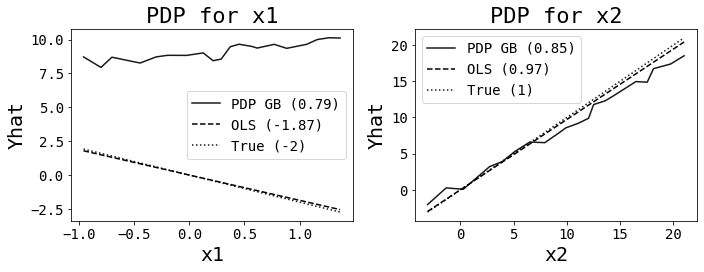

In [62]:
# now run Gradient Boosting Regression
drop_outliers = True
pmin = 0.1
pmax = 0.9
reg_gb = GradientBoostingRegressor(random_state=0,max_depth=5, learning_rate=0.5,
                                  n_estimators=100).fit(xdf, ydf.values.flatten())
# compute slope
slopes = compute_pdp_slope(xdf=xdf, 
                            model=reg_gb, 
                            drop_outliers=drop_outliers, 
                            pmin=pmin, pmax=pmax)

fig, ax = plt.subplots(1,2)
for i, var in enumerate(['x1','x2']):
    # Get the slopes for both methods
    slope_i = slopes.slope.loc[var].round(decimals=2)
    ols_i = alphay[i].round(decimals=2)
    true_i = true_pars[i]
    # plot
    ax[i], y_pred, flag_line = plot_pdp(xdf=xdf, name_var = var, model=reg_gb, ax=ax[i], 
                  ydf_string = 'Score', drop_outliers = drop_outliers, pmin = pmin, pmax = pmax)
    ols_pdp = alphay[i]*y_pred.index
    ax[i].plot(y_pred.index, ols_pdp, color = 'k', ls='--')
    true_pdp = true_pars[i]*y_pred.index
    ax[i].plot(y_pred.index, true_pdp, color = 'k', ls='dotted', alpha = 0.9)
    ax[i].legend([f'PDP GB ({slope_i})', f'OLS ({ols_i})', f'True ({true_i})'])

## Confounders

* Simulate the case of $w \rightarrow y$ and $w \rightarrow x$
* We can then run two separate regressions:

$$
y = \alpha_0 + \alpha_1 x + \epsilon \hspace{2mm}(\text{spurious regression})
$$

$$
y = \beta_0 + \beta_1 x + \beta_2 w + \eta \hspace{2mm}(\text{include the confounder as control})
$$

In [63]:
def plot_coeffs(model, labels, ax, pmin = 0.05, pmax=0.95):
    """
    Plot coefficients and 90% CI from statsmodel model object
    Inputs:
        model: statsmodel linear regression model object
        labels: string array with labels for the variables
        ax: axis object
    Outputs:
        ax: axis object with figure
    """
    params = model.params
    pvals = model.pvalues
    std_err = np.sqrt(np.diag(model.cov_params()))
    crit_val = ((pmax-pmin)+1)/2
    ci_low, ci_high = params - stats.norm.ppf(crit_val)*std_err, params + stats.norm.ppf(crit_val)*std_err
    K = len(params)
    ax.bar(range(K), params, color = '0.5', alpha = 0.5, edgecolor = 'k')
    ax.set_xticks(range(K))
    ax.set_xticklabels(labels)
    xmin, xmax = ax.get_xlim()
    ax.plot([xmin, xmax], [0,0], ls = '--', color = '0.5')
    G = 0.1
    for i in range(K):
        ax.plot([i,i],[ci_low[i], ci_high[i]], color = 'k')
        ax.plot([i-G, i+G], [ci_low[i],ci_low[i]], color = 'k')
        ax.plot([i-G, i+G], [ci_high[i],ci_high[i]], color = 'k')  
    ci_length = int(np.around((pmax - pmin)*100, decimals=0))
    ax.set_title(f'Estimated Coefficients and {ci_length}% CI')  
    ax.set_xlim([xmin, xmax])
    return ax

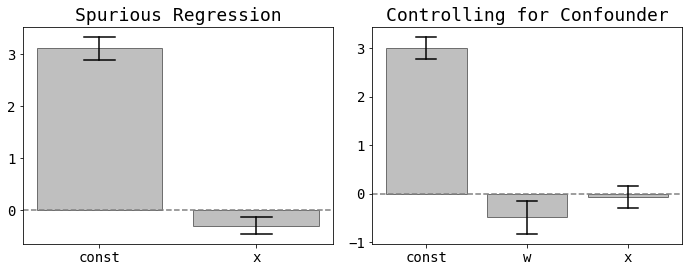

In [64]:
# DGPs
np.random.seed(10534)
var_w = 1
w = np.sqrt(var_w)*np.random.randn(nobs,1)
slope_x = 1
slope_y = -0.3
var_ex, var_ey = 1,1
x = 0.5 + slope_x*w  + np.sqrt(var_ex)*np.random.randn(nobs,1)
y = 3 + slope_y*w + np.sqrt(var_ey)*np.random.randn(nobs,1)
# arrange for training
xdf0 = pd.DataFrame(x, columns = ['x'])
xdf1 = pd.DataFrame(np.concatenate((w,x), axis=1), columns = ['w','x'])
xmat0 = sm.add_constant(xdf0)
xmat1 = sm.add_constant(xdf1)
# regressions
reg_sm0 = sm.OLS(y, xmat0).fit()
reg_sm1 = sm.OLS(y, xmat1).fit()
param_sp = reg_sm0.params.loc['x']
# plot
fig, ax = plt.subplots(1,2)
ax[0] = plot_coeffs(model=reg_sm0, labels=xmat0.columns, ax=ax[0], pmin = 0.025, pmax=0.975)
ttl = ax[0].set_title('Spurious Regression', fontsize = 18)
ax[1] = plot_coeffs(model=reg_sm1, labels=xmat1.columns, ax=ax[1], pmin = 0.025, pmax=0.975)
ttl = ax[1].set_title('Controlling for Confounder', fontsize = 18)

#### Simulate trend-stationary processes

In [65]:
def simulate_trend_ar1(nobs, coef_dict, seed):
    """
    Simulate an AR1 time series with a trend
    Inputs:
        nobs: integer: number of observations
        coef_dict: dictionary: with following keys
            'intercept': value for the intercept
            'ar1': autocorrelation coefficient for AR1 process
            'trend': coefficient for trend component
            'sigma_eps': variance for white noise
            'y_init': initial value for y (y0)
    Output:
        ydf, Xdf: dataframes with features and simulated y
    """
    # assign coefficients:
    intercept = coef_dict['intercept']
    rho = coef_dict['ar1']
    beta = coef_dict['trend']
    sigma_eps = coef_dict['sigma_eps']
    y0 = coef_dict['y_init']
    # Simulation
    np.random.seed(seed)
    white_noise = np.sqrt(sigma_eps)*np.random.randn(nobs)
    # AR1 process needs to be generated iteratively
    ydf = pd.DataFrame(index = range(nobs), columns = ['y'], dtype='float')
    xdf = pd.DataFrame(index = range(nobs), columns = ['y_lag', 'trend'], dtype='float')
    xdf['trend'] = np.arange(nobs)  # linear trend
    ydf.y.loc[0] = y0
    for i in range(1,nobs):
        ydf.y.loc[i] = intercept + rho*ydf.y.loc[i-1] + beta*i + white_noise[i]
        xdf.y_lag.loc[i] = ydf.y.loc[i-1]
    
    return ydf, xdf
    

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Text(0.5, 1.0, 'Example of a Trend Stationary AR(1) Process')

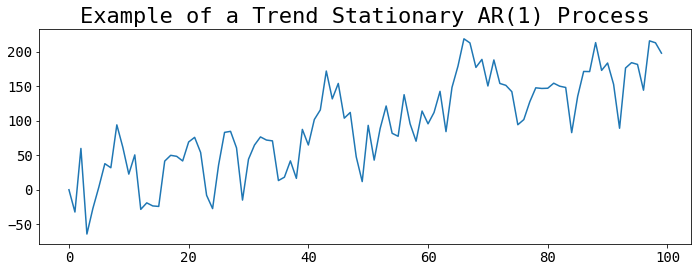

In [66]:
nobs = 100
coef_dict = {'intercept' : 1, 
             'ar1' : 0.5,
             'trend' : 1,
             'sigma_eps' : 1000,
             'y_init' : 0}
seed = 14751
y_t, x_t = simulate_trend_ar1(nobs, coef_dict, seed)
fig, ax = plt.subplots()
y_t.y.plot(ax = ax)
ax.set_title('Example of a Trend Stationary AR(1) Process')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Text(0.5, 1.0, 'Example of Trend Stationary AR(1) Processes')

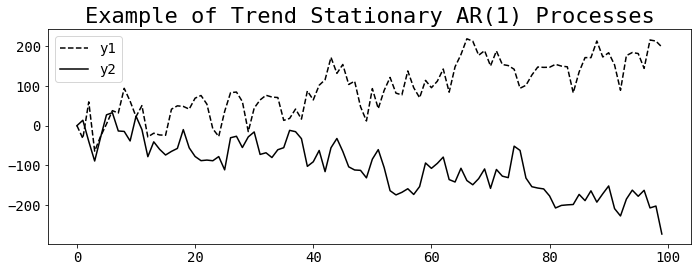

In [67]:
# simulate two processes that are uncorrelated but have a common trend
coef_dict1 = {'intercept' : 1, 
             'ar1' : 0.5,
             'trend' : 1,
             'sigma_eps' : 1000,
             'y_init' : 0}
coef_dict2 = {'intercept' : 1, 
             'ar1' : 0.5,
             'trend' : -1,
             'sigma_eps' : 1000,
             'y_init' : 0}
seed1 = 14751
seed2 = 5170
y1_t, x1_t = simulate_trend_ar1(nobs, coef_dict1, seed1)
y2_t, x2_t = simulate_trend_ar1(nobs, coef_dict2, seed2)
fig, ax = plt.subplots()
y1_t.y.plot(ax = ax, color = 'k', ls = '--')
y2_t.y.plot(ax = ax, color = 'k', ls = '-')
ax.legend(['y1', 'y2'])
ax.set_title('Example of Trend Stationary AR(1) Processes')

Text(0.5, 1.0, 'OLS of Uncorrelated Trend-Stationary Time Series (95% CI)')

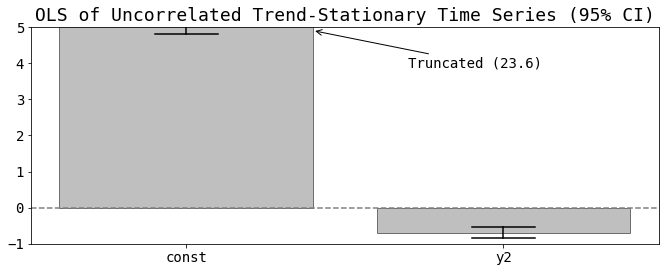

In [68]:
# run a regression of y1 on y2
xdf_t = pd.DataFrame(y2_t.values.flatten(), columns = ['y2'])
ydf_t = pd.DataFrame
xmat_t = sm.add_constant(xdf_t)
reg_sm_t = sm.OLS(y1_t, xmat_t).fit()
fig, ax = plt.subplots()
ax = plot_coeffs(model=reg_sm_t, labels=xmat_t.columns, ax=ax, pmin = 0.025, pmax=0.975)
ax.set_ylim([-1,5])
xticks = ax.set_xticks([0,1])
intercept = reg_sm_t.params.loc['const'].round(decimals=1)
ax.annotate(f"Truncated ({intercept})",xy=(0.4, 4.9), xytext=(0.7, 4.0), verticalalignment='center',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
ax.set_title('OLS of Uncorrelated Trend-Stationary Time Series (95% CI)', fontsize = 18)

## Regression by Backfitting

In [69]:
def reg_backfitting(ydf, xdf):
    """
    Regression by backfitting.  Find least squares estimates using backfitting algorithm
    At each iteration:
        res_k: y - X(-k)'beta(-k)
        Update beta_k <- OLS(res_k, x_k)
    Inputs:
        ydf, xdf: dataframes with outcome and features
    Outputs:
        beta_df: DF with full path of estimated coefficients
        beta_ols: DF with OLS results for comparison
    
    """
    nobs, nvar = xdf.shape
    beta = np.zeros((1,nvar)) # initialize with zeros
    #beta = np.array([ydf.y.mean()]*nvar).reshape((1,nvar))  # you can initialize with ymean
    dist = 1  # initialize distance
    columns = xdf.columns
    counter = 0
    max_iter = 100
    while dist > 1e-3 and counter < max_iter:
        beta_iter = np.zeros((1,nvar))
        for c,col in enumerate(columns):
            # Compute res(-k) = y = x(-k)beta(-k)
            ix_included = np.where(columns != col)[0]
            cols_included = columns[ix_included]
            x_incl = xdf[cols_included]
            beta_inc  = beta[-1,ix_included]
            res_exc_col = ydf.y.values - np.dot(x_incl, beta_inc.T)
            # regression of res(-k) on x_k
            reg_c = LinearRegression().fit(X=xdf[[col]], y=res_exc_col)  # run regression
            beta_c = reg_c.coef_[0]
            beta_iter[0,c] = beta_c
        # save beta from this iteration
        beta = np.concatenate((beta, beta_iter), axis=0)
        # update distance
        if counter > 1:
            curr_beta = beta[counter,:]
            prev_beta = beta[counter-1,:]
            max_diff = np.max(curr_beta-prev_beta)
            dist = np.abs(max_diff)
        counter+=1
    beta_df = pd.DataFrame(beta, columns = columns)
    # run OLS for comparison
    reg = LinearRegression().fit(X=xdf, y=ydf.values.flatten())
    beta_ols = pd.Series(reg.coef_, index = columns, name = 'ols')
    return beta_ols, beta_df

In [70]:
# INDEPENDENT features
alpha = [2, -7, 3.5, -2, 3]
var_x = [2]*4
vcv_x = np.diag(var_x)
rho = 0.0
var_epsilon = 1
seed = 44169
nobs = 100
ydf, Xdf = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                                        seed=seed, nobs=nobs, rho=None)
# backfitting
cols = ['x1','x2','x3','x4']
b_ols, b_bf = reg_backfitting(ydf, xdf=Xdf[cols])


In [71]:
# Correlated features
rho = 0.5
ydf_rho, Xdf_rho = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                                        seed=seed, nobs=nobs, rho=rho)
# backfitting
b_ols_rho, b_bf_rho = reg_backfitting(ydf_rho, xdf=Xdf_rho[cols])


In [72]:
def plot_backfitting(beta_ols, beta_bf, ax, rho):
    "Plot backfitting iterations"
    nvars = beta_ols.shape[0]
    colors = [f'{col}' for col in np.linspace(0,0.6,nvars)]
    beta_bf.plot(ax=ax, color = colors)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_xlim()
    for n, nme in enumerate(beta_ols.index):
        y_n = beta_ols.loc[nme]
        ax.plot([xmin,xmax], [y_n, y_n], ls = '--', color = colors[n])
    #ax.set_xlim([0,6])
    if rho is not None:
        str_title = f'OLS - Backfitting: rho = {rho}'
    else:
        str_title = f'OLS - Backfitting: Independent'
    ax.set_title(str_title)
    ax.legend(bbox_to_anchor=(1.13, 1.0))
    ax.set_xlabel('Iterations')   
    return ax

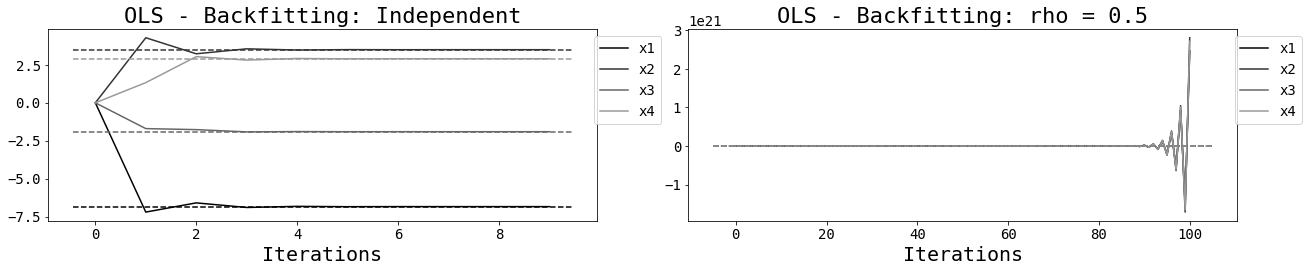

In [73]:
fig, ax = plt.subplots(1,2, figsize = (18,4))
ax[0] = plot_backfitting(beta_ols=b_ols, beta_bf=b_bf, ax=ax[0], rho = None)
ax[1] = plot_backfitting(beta_ols=b_ols_rho, beta_bf=b_bf_rho, ax=ax[1], rho = rho)

## Additional variables
* What happens if you include more variables _than needed_?

**Strategy**:
* Simulate a simple linear model $y = \alpha + \beta x + \epsilon$
* Include more unrelated features $\mathbf{Z}$ but correlated to $x$
* Estimate bias

In [74]:
def simulate_linear_extra_vars(alpha, rho, nvars, var_epsilon, nobs, seed):
    """
    Simulate linear model y = alpha + beta*x, and Z correlated with x
    """
    np.random.seed(seed)
    K = len(alpha)
    alpha = np.array(alpha).reshape((K,1))   # make it a column vector
    # Simulate Z features
    zdf = simulate_xmatrix_rho(nobs, nfeats=nvars, rho=rho, seed=seed)
    xdf = pd.DataFrame(zdf.values[:,0], columns = ['x1'])
    xdf['x0'] = 1
    xdf = xdf[['x0','x1']]
    epsilon = np.sqrt(var_epsilon)*np.random.randn(nobs,1)
    y = np.dot(xdf.values, alpha) + epsilon
    ydf = pd.DataFrame(y, columns = ['y'])
    return ydf, xdf, zdf    

In [75]:
alpha = [1,0]
rho = 0
nvars = 2
var_epsilon = 0
nobs = 2
seed = 105
y_test, x_test, z_test = simulate_linear_extra_vars(alpha, rho, nvars, var_epsilon, nobs, seed)
assert np.all(y_test==1)
z_test, x_test

(         x1        x2
 0 -0.245326 -0.613352
 1 -0.726768  0.059366,
    x0        x1
 0   1 -0.245326
 1   1 -0.726768)

In [76]:
def run_montecarlo_linear_addvars(alpha, rho, nvars, var_epsilon, nobs, num_montecarlo, seed_mc):
    """
    Run an MC simulation with more variables than needed (opposite of omitted variables)
    Inputs:
        alpha: float array with [intercept, slope] (bivariate regression)
        rho: Correlation coefficient to generate Z~N(0,Sigma(rho))
        nvars: Number of total variables (additional = nvars-1)
        var_epsilon: Residual variance
        nobs: Number of observations
        num_montecarlo: Number of MC simulations
        seed_mc: Seed of seeds for MC
    Outputs:
        
    """
    # step 1, simulate the true DGP with only one feature AQUI
    np.random.seed(seed_mc)
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    K = len(alpha)
    col_labels = [f'x{num}' for num in range(1,nvars+1)]
    df_ols = pd.DataFrame(index = range(num_montecarlo), columns = col_labels, dtype='float')
    df_gb = pd.DataFrame(index = range(num_montecarlo), columns = col_labels, dtype='float')
    for i in range(num_montecarlo):
        ydf, xdf, zdf = simulate_linear_extra_vars(alpha, rho, nvars, var_epsilon, nobs, seed=seed_arr[i])
        # Linear regression: note that Zdf doesn't include the intercept
        reg = LinearRegression().fit(zdf, ydf)
        alpha_hat = reg.coef_.flatten()
        df_ols.loc[i] = alpha_hat
        # Plain-vanilla GB (no metaparameter optimization)
        modgb = GradientBoostingRegressor(random_state=1283).fit(zdf, ydf.values.flatten())
        df_pre_gb = compute_pdp_slope(xdf=zdf, model=modgb, drop_outliers=drop_outliers, 
                                     pmin=pmin, pmax=pmax)
        df_gb.loc[i] = df_pre_gb.slope.values
    # compute bias: first I need dims to match
    true_params = np.array([0]*nvars)
    true_params[0] = alpha[1]  # first should be the slope of the true DGP
    bias_ols = df_ols - true_params
    bias_gb = df_gb - true_params

    #return bias_ols, bias_gb
    return df_ols, df_gb

In [77]:
alpha = [1,3]
rho = 0.5
nvars = 5
var_epsilon = 1
nobs = 100
num_montecarlo = 300
seed_mc = 105
t_ols, t_gb = run_montecarlo_linear_addvars(alpha, rho, nvars, var_epsilon, nobs, num_montecarlo, seed_mc)
bounds_ols = create_means_bounds_mc(df=t_ols, qmin = 0.05, qmax = 0.95)
bounds_gb = create_means_bounds_mc(df=t_gb, qmin = 0.05, qmax = 0.95)

In [78]:
bounds_ols['x1'].loc[['percentile_ 5']]

percentile_ 5    2.755212
Name: x1, dtype: float64

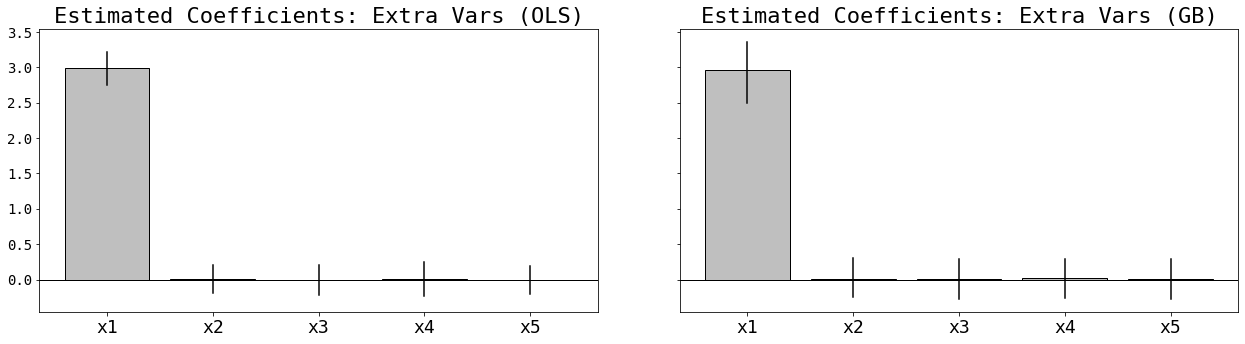

In [79]:
fig, ax = plt.subplots(1,2, figsize = (18,5), sharey=True)
dict_bd = {0:bounds_ols, 1:bounds_gb}
dict_ttl = {0:'OLS', 1:'GB'}
for i in range(2):
    df_i = dict_bd[i]
    k_i = len(df_i.columns)
    ax[i].bar(range(k_i), df_i.loc['mean'], edgecolor = 'k', facecolor = '0.75')
    for c, col in enumerate(df_i.columns):        
        min_c, max_c = df_i[col].loc[['percentile_ 5','percentile_95']]
        ax[i].plot([c,c],[min_c, max_c], ls = '-', color = 'k')
    ax[i].set_title(f'Estimated Coefficients: Extra Vars ({dict_ttl[i]})')
    xmin, xmax = ax[i].get_xlim()
    ax[i].plot([xmin, xmax], [0,0], color = 'k', ls = '-', lw=1)
    ax[i].set_xlim([xmin, xmax])
    ax[i].set_xticks(range(k_i))
    ax[i].set_xticklabels(df_i.columns, fontsize=18)
    

##### Not included in the chapter but useful

* Ensembles are sensitive to correlated features even if not important.
* Next simulation
    * I include several uninformative features (2,3,4)
    * Simulate a matrix $Z \sim N(0, \Sigma(\rho))$ parameterized by the degree of correlation 
    * I create a grid of correlation parameters
* I want to show that OLS is relatively insensitive to this correlation
* While GB is not

In [80]:
# let's simulate on two fronts: correlation grid AND number of extra vars
rho_grid = np.linspace(0.5,0.99,5)
var_grid = range(2,5)  # 2, 3 and 4 features
beta_ols_mc = pd.DataFrame(index = rho_grid, columns = var_grid)
beta_gb_mc = pd.DataFrame(index = rho_grid, columns = var_grid)
for r, rho_r in enumerate(rho_grid):
    for v, nvar_r in enumerate(var_grid):
        ols_v, gb_v = run_montecarlo_linear_addvars(alpha = alpha, 
                                                    rho = rho_r, 
                                                    nvars = nvar_r, 
                                                    var_epsilon = var_epsilon, 
                                                    nobs = nobs, 
                                                    num_montecarlo = num_montecarlo, 
                                                    seed_mc = seed_mc)
        # get descriptive statistics
        bounds_ols = create_means_bounds_mc(df=ols_v, qmin = 0.05, qmax = 0.95)['x1'].values
        bounds_gb = create_means_bounds_mc(df=gb_v, qmin = 0.05, qmax = 0.95)['x1'].values        
        # save results
        beta_ols_mc[nvar_r].loc[rho_r] = ols_v['x1'].mean()
        beta_gb_mc[nvar_r].loc[rho_r] = gb_v['x1'].mean()
        #beta_ols_mc[nvar_r].loc[rho_r] = [val for val in bounds_ols]
        #beta_gb_mc[nvar_r].loc[rho_r] = [val for val in bounds_gb]

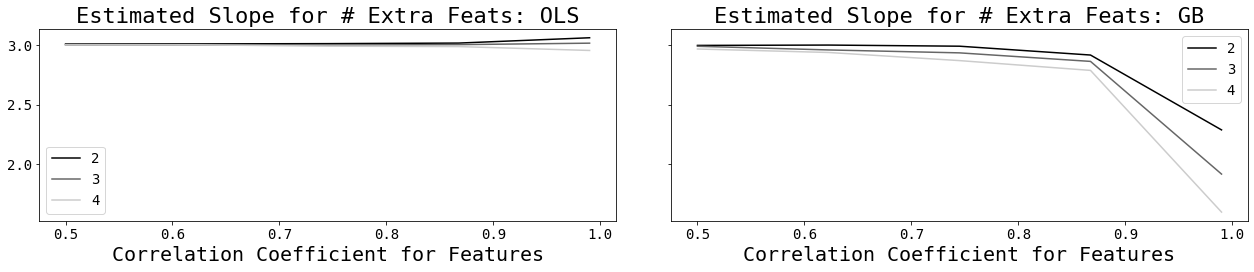

In [81]:
fig, ax = plt.subplots(1,2, figsize = (18,4), sharey = True)
colors = ['0.0', '0.4', '0.8']
beta_ols_mc.plot(kind='line', ax = ax[0], color = colors)
beta_gb_mc.plot(kind='line', ax = ax[1], color = colors)
for i in range(2):
    ax[i].set_title(f'Estimated Slope for # Extra Feats: {dict_ttl[i]}')
    ax[i].set_xlabel('Correlation Coefficient for Features')

## Why we care about variance

In [82]:
def compute_vn_entropy(xdf):
    """
    Compute Von Neumann Entropy = - SUM(lambda * ln(lambda)) 
        lambda: eigenvalues of X'X
    """
    # compute the eigenvalues
    xmat = xdf.values
    xtx = np.dot(xmat.T, xmat)
    evals, evec = LA.eig(xtx)
    evals /= np.sum(evals)
    # compute entropy
    entropy = -np.sum(evals*np.log(evals))
    return entropy


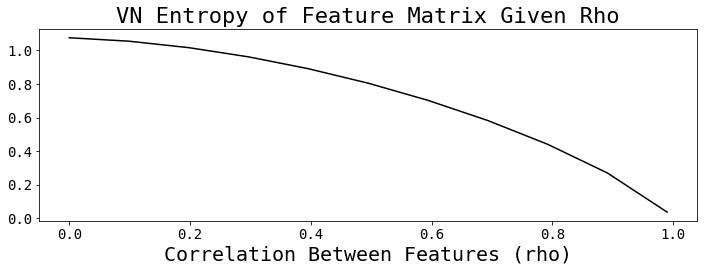

In [83]:
n_grid = 11
max_rho = 0.99
rho_grid = np.linspace(0, max_rho, n_grid)
seed = 35011
df_entropy = pd.DataFrame(index = rho_grid, columns = ['entropy'])
for r, rho in enumerate(rho_grid):
    x_r = simulate_xmatrix_rho(nobs=100, nfeats=3, rho=rho, seed = seed)
    vn_r = compute_vn_entropy(xdf=x_r)
    df_entropy.entropy.loc[rho] = vn_r

fig, ax = plt.subplots()    
df_entropy.plot(ax=ax, color = 'k')
ax.set_title('VN Entropy of Feature Matrix Given Rho')
ax.set_xlabel('Correlation Between Features (rho)')
ax.get_legend().remove()

## 1. Show impact of variance on estimation

In [84]:
def run_montecarlo_linear(alpha, vcv_x, var_epsilon, nobs, num_montecarlo, seed_mc):
    """
    Run a Montecarlo simulation with a linear model
    Inputs:
        alpha: array with K user-provided coefficients (includes intercept)
        vcv_x: array of dimension (K-1)x (K-1) covariance matrix for X.  Must be positive definite
        var_epsilon: variance for normal errors
        nobs: number of observations in the sample
        num_montecarlo: number of montecarlo samples
        seed_mc: seed for the seeds of each simulation
    output: 
        df_alpha: dataframe with the estimted coefficients (size= num_montecarlo x K)
    """
    np.random.seed(seed_mc) # seed for generating a random seed: needed to get different samples
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    K = len(alpha)
    col_labels = [f'x{num}' for num in range(K)]
    df_ols = pd.DataFrame(index = range(num_montecarlo), columns = col_labels, dtype='float')
    df_gb = pd.DataFrame(index = range(num_montecarlo), columns = col_labels, dtype='float')
    for i in range(num_montecarlo):
        ydf, Xdf = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                                            seed=seed_arr[i], nobs=nobs)
        reg = LinearRegression(fit_intercept=False).fit(Xdf, ydf)  # run regression
        alpha_hat = reg.coef_.flatten()
        df_ols.loc[i] = alpha_hat
        # Plain-vanilla GB (no metaparameter optimization)
        modgb = GradientBoostingRegressor(random_state=1283).fit(Xdf, ydf.values.flatten())
        df_pre_gb = compute_pdp_slope(xdf=Xdf, model=modgb, drop_outliers=drop_outliers, 
                                     pmin=pmin, pmax=pmax)
        df_gb.loc[i] = df_pre_gb.slope.values

        
    return df_ols, df_gb

In [85]:
# I want to simulate a model, but variances vary from very low to large
alpha = [2, 3.5]
var_x = [0.01]
vcv_x = np.diag(var_x)
var_epsilon = 1
seed = 44191
nobs = 100
ydf, Xdf = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                                        seed=seed, nobs=nobs)
Xdf.var()

x0    0.000000
x1    0.011226
dtype: float64

In [86]:
# create a grid of variances to estimate bias
G = 20
gmax = 3
var_grid = np.linspace(0.1, gmax, G)
seed_mc = 71450
num_montecarlo = 100
df_results_ols = pd.DataFrame(index = var_grid, columns = ['mean', 'min_ci', 'max_ci'], dtype='float')
df_results_gb = pd.DataFrame(index = var_grid, columns = ['mean', 'min_ci', 'max_ci'], dtype='float')
for g, grd in enumerate(var_grid):
    var_x = [grd]
    vcv_x = np.diag(var_x)
    df_g_ols, df_g_gb = run_montecarlo_linear(alpha, vcv_x, var_epsilon, nobs, num_montecarlo, seed_mc=seed_mc)
    ci_ols = create_means_bounds_mc(df=df_g_ols, qmin = 0.05, qmax = 0.95)
    ci_gb = create_means_bounds_mc(df=df_g_ols, qmin = 0.05, qmax = 0.95)
    df_results_ols.loc[grd] = ci_ols['x1'].values
    df_results_gb.loc[grd] = ci_gb['x1'].values


In [87]:
df_results_gb.head(2)

,mean,min_ci,max_ci
0.100000,3.470934,2.945947,4.056516
0.252632,3.481713,3.151416,3.850134


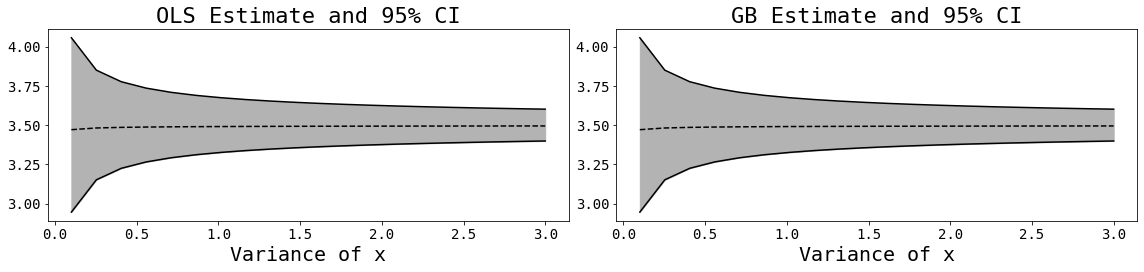

In [88]:
fig, ax = plt.subplots(1,2, figsize = (16,4))
dict_meth = {0:df_results_ols, 1:df_results_gb}
for i in range(2):
    df_i = dict_meth[i]
    df_i[['min_ci', 'max_ci']].plot(ax = ax[i], color = 'k')
    df_i['mean'].plot(ax=ax[i], color='k', ls='--')
    ax[i].fill_between(df_i.index, df_i.max_ci, df_i.min_ci, color = '0.7')
    ax[i].get_legend().remove()
    ax[i].set_title(f'{dict_ttl[i]} Estimate and 95% CI')
    ax[i].set_xlabel('Variance of x')

## Grouping variables

* I want to show that a regression of the form 

$$
y_{is} = \alpha + \beta x + \sum_s \theta_s D_s + \eta \overline{z}_s+\epsilon_{is}
$$

* Let's simulate this model: the only new thing is that I draw the dummies $D_s$ from a multinomial distribution

In [89]:
# simulation
np.random.seed(9110)
nobs = 100
alph = 5
beta = 3
theta = [-1,1]  # three states, leaving out one as reference 
eta = -2
sigma_eps = 1
epsilon = np.sqrt(sigma_eps)*np.random.randn(nobs,1)
# simulate x and z as normal
sigma_x = 0.1
x = np.sqrt(sigma_x)*np.random.randn(nobs)
sigma_z = 10
mu_z = 7
zdf = pd.DataFrame(mu_z + np.sqrt(sigma_z)*np.random.randn(nobs), columns = ['z'])
# Simulate state dummies: multinomial
dummies = pd.DataFrame(np.random.multinomial(n=1, pvals = [0.2, 0.5, 0.3], size = nobs), 
                      columns = [f'D{i}' for i in range(3)])
# convert to a categorical variable to compute means
dummies['cat'] = 1*dummies['D0'] + 2*dummies['D1'] + 3*dummies['D2']
means_dict = zdf.z.groupby(dummies.cat).mean().to_dict()
dummies['mean_z'] = dummies.cat.replace(means_dict)
Xdf = pd.DataFrame([1]*nobs, columns = ['x0'])
Xdf['x1'] = x
Xdf[['D1','D2','mean_z']] = dummies[['D1','D2','mean_z']]
alpha_array = np.array([alph, beta,theta[0], theta[1], eta]).reshape((5,1))
ydf = np.dot(Xdf, alpha_array) + epsilon

In [90]:
# Show that X is not full column rank (and thus, won't be invertible)
print(f'Columns of X = {Xdf.columns.values}')
rank_x = LA.matrix_rank(Xdf)
nvars = Xdf.shape[1]
print(f'X: Rank = {rank_x}, total columns = {nvars}')
# what happens if we drop the means?
X_nm = Xdf[[col for col in Xdf.columns if col != 'mean_z']]
rank_xnm = LA.matrix_rank(X_nm)
nvars_nm = X_nm.shape[1]
print(f'X_[-meanz]: Rank = {rank_xnm}, total columns = {nvars_nm}')


Columns of X = ['x0' 'x1' 'D1' 'D2' 'mean_z']
X: Rank = 4, total columns = 5
X_[-meanz]: Rank = 4, total columns = 4


In [91]:
# what happens if I try to run LinearRegression
reg_lr = LinearRegression(fit_intercept = False).fit(Xdf, ydf)
print(f'OLS coefficients from Scikit-learn = {reg_lr.coef_}')
# But matrix is singular!
xtx = np.dot(Xdf.T, Xdf)
detX = LA.det(xtx)
print(f'Determinant Original Xdf = {detX}')  # Det = 0!  Non-invertible
xtx0 = np.dot(X_nm.T, X_nm)
xtx0_inv = LA.inv(xtx0)
detX0 = LA.det(xtx0)
print(f'Determinant Xdf exc. meanz = {detX0}')  # Det>0 --> invertible


OLS coefficients from Scikit-learn = [[-0.15045264  3.29509116 -1.02220311  0.94077808 -1.14096089]]
Determinant Original Xdf = -1.6837144268033516e-06
Determinant Xdf exc. meanz = 277346.46779820765


In [92]:
# what about gradient boosting?
def compute_test_mse_gb(Xdf, ydf):
    "Run plain-vanilla GBR and compute the mse on the test sample"
    # split the samples and train
    X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf, random_state=0)
    reg = GradientBoostingRegressor(random_state=0).fit(X_train, y_train.flatten())
    y_hat = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_hat)
    return mse, y_test

In [93]:
mse_original, y_o = compute_test_mse_gb(Xdf, ydf)
mse_dropped, y_d = compute_test_mse_gb(X_nm, ydf)
# test that test samples are the same!
assert np.all(y_o==y_d)
print(mse_original, mse_dropped)

1.47464019303549 1.4675499901751963


In [94]:
# run an MC to ensure that there's no improved predictive performance
def simulate_state_model(alpha, nobs, seed):
    "Simulate a version of the model with state dummies"
    np.random.seed(seed)
    alph = alpha[0]
    beta = alpha[1]
    theta = alpha[2:4]  # three states, leaving out one as reference 
    eta = alpha[4]
    epsilon = np.random.randn(nobs,1)
    # simulate x and z as normal
    x = np.random.randn(nobs)
    sigma_z = 10
    mu_z = 7
    zdf = pd.DataFrame(mu_z + np.sqrt(sigma_z)*np.random.randn(nobs), columns = ['z'])
    # Simulate state dummies: multinomial
    dummies = pd.DataFrame(np.random.multinomial(n=1, pvals = [0.2, 0.5, 0.3], size = nobs), 
                          columns = [f'D{i}' for i in range(3)])
    # convert to a categorical variable to compute means
    dummies['cat'] = 1*dummies['D0'] + 2*dummies['D1'] + 3*dummies['D2']
    means_dict = zdf.z.groupby(dummies.cat).mean().to_dict()
    dummies['mean_z'] = dummies.cat.replace(means_dict)
    Xdf = pd.DataFrame([1]*nobs, columns = ['x0'])
    Xdf['x1'] = x
    Xdf[['D1','D2','mean_z']] = dummies[['D1','D2','mean_z']]
    alpha_array = np.array([alph, beta,theta[0], theta[1], eta]).reshape((5,1))
    ydf = np.dot(Xdf, alpha_array) + epsilon

    # check rank condition as test
    rank_x = LA.matrix_rank(Xdf)
    assert rank_x == len(Xdf.columns) - 1

    return ydf, Xdf

alpha = [5,3,-1,1,-2]
nobs = 100
seed = 93193
ys_df, xs_df = simulate_state_model(alpha, nobs, seed)

In [95]:
def run_mc_state_gbr(alpha, nobs, num_montecarlo, seed_mc):
    "Run an MC simulation of state dummies DGP"
    np.random.seed(seed_mc)
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    mse_df = pd.DataFrame(index = range(num_montecarlo), columns = ['mse_original', 'msi_dropped'])
    for i in range(num_montecarlo):
        ydf, xdf = simulate_state_model(alpha, nobs, seed = seed_arr[i])
        xdf_dr = xdf[[col for col in Xdf.columns if col != 'mean_z']]
        # compute MSEs
        mse_ori, _ = compute_test_mse_gb(xdf, ydf)
        mse_dro, _ = compute_test_mse_gb(xdf_dr, ydf)
        mse_df.loc[i] = [mse_ori, mse_dro]
        
    return mse_df

In [96]:
alpha = [5,3,-1,1,-2]
nobs = 100
seed = 93193
num_montecarlo = 300
mse_mc = run_mc_state_gbr(alpha, nobs, num_montecarlo, seed_mc)

In [97]:
bounds_mse = create_means_bounds_mc(df=mse_mc, qmin = 0.05, qmax = 0.95)
bounds_mse

,mse_original,msi_dropped
mean,1.813861,1.837272
percentile_ 5,1.074584,1.039161
percentile_95,2.713919,2.736431


[Text(0, 0, 'Complete'), Text(0, 0, 'Dropped')]

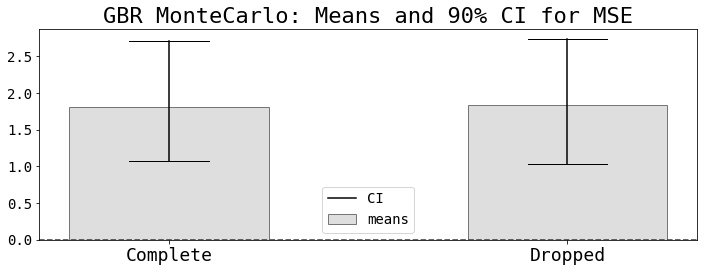

In [98]:
fig, ax = plt.subplots()
plot_conf_intervals(means=bounds_mse.loc['mean'].values, 
                    bounds=bounds_mse.loc[['percentile_ 5', 'percentile_95']].values, 
                    var_labels = bounds_mse.columns, ax=ax)
ax.set_title('GBR MonteCarlo: Means and 90% CI for MSE')
ax.set_xticklabels(['Complete', 'Dropped'], fontsize =18)

## Reverse Causality
* Simulate this now

$$
\begin{eqnarray}
y &=& \alpha_0 + \alpha_1 x + \epsilon \\
z &=& \beta_0 + \beta_1 y + \zeta
\end{eqnarray}
$$

What happens if you include $z$ as a _control_ in a regression for $y$?
$$
y = \delta_0 + \delta_1 x+ \delta_2 z + \iota
$$

**FW** says that the coefficient $\delta_2$ can be found as

$$
\delta_2 = \frac{Cov(\tilde{y}_x, \tilde{z}_x)}{Var(\tilde{z}_x)} = \frac{Cov(\epsilon, z)}{Var(z)} = 0
$$

In [99]:
def simu_bad_control(alpha, beta, nobs, seed):
    np.random.seed(seed)
    "Simulate the case of a bad control"
    # simulate y
    xdf = pd.DataFrame([1]*nobs, columns=['x0'])
    xdf['x1'] = np.random.randn(nobs)
    ydf = pd.DataFrame(np.dot(xdf, alpha) + np.random.randn(nobs), columns = ['y'])
    # simulate z
    fdf = pd.DataFrame([1]*nobs, columns=['z0'])
    fdf['y'] = y
    zdf = pd.DataFrame(np.dot(fdf, beta) + np.random.randn(nobs), columns = ['z'])
    
    return ydf, zdf, xdf, fdf

In [100]:
def run_mc_bad_control(alpha, beta, nobs, seed_mc, num_montecarlo):
    "Run an MC for bad control"
    np.random.seed(seed_mc)
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    cols = ['intercept', 'x1', 'z']
    df_ols = pd.DataFrame(index = range(num_montecarlo), columns = cols, dtype='float')
    for i in range(num_montecarlo):
        ydf, zdf, xdf, fdf = simu_bad_control(alpha, beta, nobs, seed=seed_arr[i])
        x_aug = xdf.copy()
        x_aug['z'] = zdf.z
        # run ols
        reg_i = LinearRegression(fit_intercept=False).fit(x_aug, ydf)
        df_ols.loc[i] = reg_i.coef_

        
    return df_ols

In [101]:
alpha = [-1,1]
beta =[3,-3]
nobs = 100
seed_mc = 62119
num_montecarlo = 300
mc_bad_con = run_mc_bad_control(alpha, beta, nobs, seed_mc, num_montecarlo)
bounds_bc = create_means_bounds_mc(df=mc_bad_con, qmin = 0.05, qmax = 0.95)
bounds_bc

,intercept,x1,z
mean,-0.979992,0.986434,0.002472
percentile_ 5,-1.275513,0.824417,-0.043035
percentile_95,-0.651035,1.143404,0.043756


[Text(0, 0, 'Intercept'), Text(0, 0, 'x1'), Text(0, 0, 'z')]

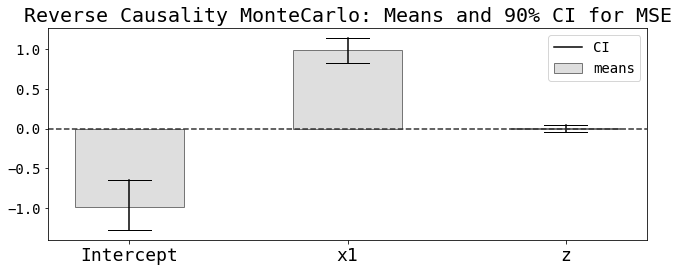

In [102]:
fig, ax = plt.subplots()
plot_conf_intervals(means=bounds_bc.loc['mean'].values, 
                    bounds=bounds_bc.loc[['percentile_ 5', 'percentile_95']].values, 
                    var_labels = bounds_bc.columns, ax=ax)
ax.set_title('Reverse Causality MonteCarlo: Means and 90% CI for MSE', fontsize=20)
ax.set_xticklabels(['Intercept', 'x1','z'], fontsize =18)

## Fraud: feature machine

* The idea is this: fraudsters _don't_ know the distribution of an outcome
* We know it
* They will try to appear "normal" but we should be able to identify what "normal" is
* One alternative is to choose an extreme quantile (left or right tail) and normalize the feature with respect to this quantile --> intuition: let's help the algorithm learn what is abnormal or not

$$
Prob(y=1) = F(\alpha + \beta \frac{x}{x_q} + \epsilon \geq 0) 
$$

Where $x_q$ is some quantile of $x$, say, the 90% quantile that will serve as bench to define something abnormal

In [50]:
def simulate_fraud_probability(alpha, nobs, sigma_x, sigma_eps, seed):
    "Simulate the probability of fraud"
    np.random.seed(seed)
    x = np.random.lognormal(mean=0, sigma = sigma_x, size = nobs)  # assume log-normality
    x90 = np.percentile(x, 90)
    xnorm = x/x90
    z = alpha[0] + alpha[1]*xnorm + np.sqrt(sigma_eps)*np.random.randn(nobs)
    y = 1*(z>=0)
    xdf = pd.DataFrame([1]*nobs, columns = ['x0'])
    xdf['x'] = x
    xdf['xnorm'] = xnorm
    ydf = pd.DataFrame(y, columns=['y'])
    return ydf, xdf

Text(0.5, 1.0, 'Normalized vs. OriginalFeature')

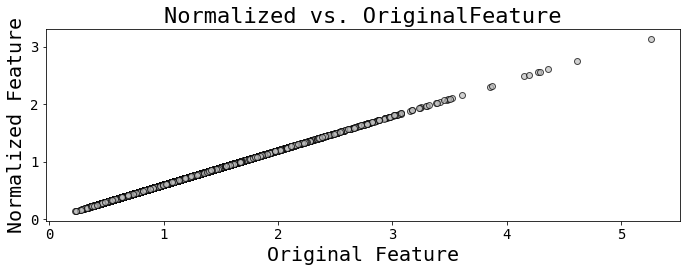

In [112]:
alpha = [2,-10]
sigma_x, sigma_eps = 0.4, 1
seed = 61514
nobs = 10000
y_t, x_t = simulate_fraud_probability(alpha, nobs, sigma_x, sigma_eps, seed)
y_t.mean()
# check the histogram of the two features
fig, ax = plt.subplots()
ax.scatter(x_t['x'], x_t['xnorm'], facecolor='0.75', edgecolor='k', alpha= 0.7)
ax.set_xlabel('Original Feature')
ax.set_ylabel('Normalized Feature')
ax.set_title('Normalized vs. OriginalFeature')

In [55]:
# what about gradient boosting?
def compute_test_mse_model(Xdf, ydf, model):
    "MSE for a given model object"
    y_hat = model.predict(Xdf)
    mse = mean_squared_error(ydf, y_hat)
    return mse

In [56]:
def balance_data(ydf, xdf, method):
    '''
    Balance the dataset using one method: over/under sampling
    ydf, xdf: dataframes with outcome and features
    method: ['over','under']
    '''
    # find minority class: if mean < 0.5 -> minority class = 1
    min_class = 1*(ydf.mean() < 0.5)
    # get indices for classes
    loc_min = ydf == min_class
    min_ix = ydf[loc_min].index
    max_ix = ydf[loc_min==False].index
    n_min = len(min_ix)
    n_max = len(max_ix)
    if method == 'over':
        num_sml = n_max//n_min
        sml_ix = np.random.choice(min_ix, size = n_max, replace = True)
        sml_all = np.concatenate((sml_ix, max_ix),axis = 0)
    elif method == 'under':
        sml_ix = np.random.choice(max_ix, size = n_min, replace = True)
        sml_all = np.concatenate((sml_ix, min_ix),axis = 0)
    # ready to assemble everything
    y_new = ydf.loc[sml_all]
    x_new = xdf.loc[sml_all]
    return y_new, x_new

In [105]:
def run_mc_fraud(alpha, nobs, sigma_x, sigma_eps, seed_mc, num_montecarlo):
    "Run MC for fraud: estimate OLS and GBC"
    # step 1, simulate the true DGP with only one feature AQUI
    np.random.seed(seed_mc)
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    K = len(alpha)
    cols = ['mse_ols', 'mse_ols_norm', 'mse_gb', 'mse_gb_norm']
    df_results = pd.DataFrame(index = range(num_montecarlo), columns = cols)
    for i in range(num_montecarlo):
        # create dataset, split into train/test and balance train sample only
        ydf, xdf_pre = simulate_fraud_probability(alpha, nobs, sigma_x, sigma_eps, seed = seed_arr[i])
        X_train, X_test, y_train, y_test = train_test_split(xdf_pre, ydf, random_state=0)
        xdf_train, xdf_test = X_train[['x']], X_test[['x']]
        xdf_train_norm, xdf_test_norm = X_train[['xnorm']], X_test[['xnorm']]
        y_b, x_b = balance_data(ydf=y_train, xdf=xdf_train, method='over')
        y_b_norm, x_b_norm = balance_data(ydf=y_train, xdf=xdf_train_norm, method='over')
        # Now the models: linear probability model and a 
        reg = LinearRegression().fit(x_b, y_b.values.flatten())
        reg_norm = LinearRegression().fit(x_b_norm, y_b_norm.values.flatten())
        gb = GradientBoostingRegressor(random_state=1283).fit(x_b, y_b.values.flatten())
        gb_norm = GradientBoostingRegressor(random_state=1283).fit(x_b_norm, y_b_norm.values.flatten())
        # I want to compute MSE in test
        mse_ols = compute_test_mse_model(xdf_test, y_test, model=reg)
        mse_ols_norm = compute_test_mse_model(xdf_test_norm, y_test, model=reg_norm)
        mse_gb = compute_test_mse_model(xdf_test, y_test, model=gb)
        mse_gb_norm = compute_test_mse_model(xdf_test_norm, y_test, model=gb_norm)
        # save
        df_results.loc[i] = [mse_ols, mse_ols_norm, mse_gb, mse_gb_norm]

    return df_results

In [106]:
alpha = [2,-10]
sigma_x, sigma_eps = 0.4, 1
num_montecarlo = 300
seed_mc = 61514
nobs = 10000
df_mc_fraud = run_mc_fraud(alpha, nobs, sigma_x, sigma_eps, seed_mc, num_montecarlo)

Text(0.5, 1.0, 'MSE Fraud Simulation')

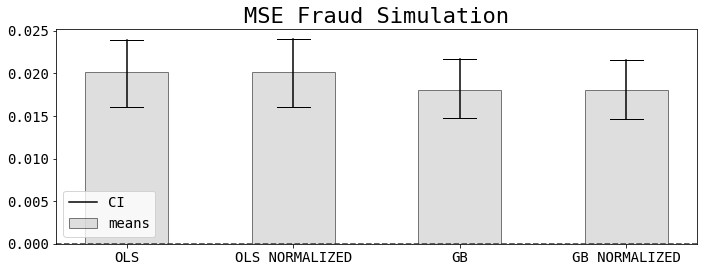

In [107]:
df_fr_bounds = create_means_bounds_mc(df=df_mc_fraud, qmin = 0.05, qmax = 0.95)
means = df_fr_bounds.loc['mean']
bounds = df_fr_bounds.loc[['percentile_ 5','percentile_95']].values
fig, ax = plt.subplots()
ax = plot_conf_intervals(means, bounds, var_labels = df_fr_bounds.columns, ax=ax)
ax.set_xticks(range(4))
labs = [col.replace('mse_','').replace('_', ' ').replace('norm',
                                                         'normalized').upper() for col in df_fr_bounds.columns]
labs = ax.set_xticklabels(labs)
ax.set_title('MSE Fraud Simulation')